# Loading a Previous Model and Cross-Checking

This notebook will take you through the steps necessary to train an LSTM to recognize ICD-9 codes, or items from similar dictionaries, from free text.

## Setup

### Imports

Make sure that the below packages are installed on the server on which this program will run.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('src/taggerSystem/')
from data_util import load_and_preprocess_data, load_embeddings, ModelHelper, lastTrueWordIdxs
import tensorflow as tf
from simpleLSTMWithNNetModel import Model, reloadModel
from trainModel import trainModel
import os
import pprint
import numpy as np
import pickle
pp = pprint.PrettyPrinter(indent=4)

### Directories

Executing the following cell will prompt the user to type in the directories corresponding to the training and validation sets, the vocabulary, and the word vector mappings. Defaults are given in the comments below.

Note that the training and test data needs to have one column dedicated to free text (`noteIdx`) and another dedicated to top-level ICD-9 codes (`codeIdx`) associated with each patient. Preferably, the latter should be strung together using '-' as the delimiter (e.g. for patient 1, 1-2-6-4).

Please make sure that the parameters such as the embed size, maximum note length, learning rate, number of maximum training epochs, batch size, hidden layer size, number of neural net layers, and probabilities are to your specification.

### Put sample file with require file headers:

adjust training data headers to match small icd9 training file

In [3]:
data_train = raw_input('What is the path to the training data that will be used? ') #default: data/icd9NotesDataTable_train.csv
data_valid = raw_input('What is the path to the validation data that will be used? ') #default: data/icd9NotesDataTable_valid.csv
vocab = raw_input('What is the path to the vocabulary used? ') #default: data/icd9Vocab.txt
wordVecs = raw_input('What is the path to the word vectors used? ') #data/newgloveicd9.txt. These are length 300 word vectors from GloVE

NUM = "NNNUMMM"
UNK = "UUUNKKK"
EMBED_SIZE = 300 # this should correspond to the length of the word vectors
maxAllowedNoteLength = 1000
max_grad_norm = 5
codeIdx = raw_input('Which column contains top-level ICD-9 codes (outputs) in the training and test data? Default is 9. ')
textIdx = raw_input('Which column contains notes/text (inputs) in the training and test data? Default is 6. ')
learning_rate = 0.001
training_epochs = 100
batch_size = 256
n_hidden = 200
output_keep_prob = 0.5
input_keep_prob = 1
numLayers = 1

What is the path to the training data that will be used? data/0815/mimic_mm_reps_0815_train.csv
What is the path to the validation data that will be used? data/0815/mimic_mm_reps_0815_valid.csv
What is the path to the vocabulary used? data/icd9Vocab.txt
What is the path to the word vectors used? data/newgloveicd9.txt
Which column contains top-level ICD-9 codes (outputs) in the training and test data? Default is 9. 9
Which column contains notes/text (inputs) in the training and test data? Default is 6. 6


In [4]:
# NOTE:
# Fixing some issue ashley had

textIdx = int(textIdx)
codeIdx = int(codeIdx)# I'm not sure how models were trinaed before if this part was broken

Here, make sure that the output path is specified as you would like. By default, the program saves the output in a folder with the name of your choice within the folder `results`.

If there exists a folder with results that you would like to load again, use that here.

In [5]:
output_path = raw_input('Where is the model to be loaded from? ')
output_path = os.path.join('results', output_path)
if output_path == 'results/':
    output_path = 'results/temp'
if not os.path.exists(output_path):
    os.makedirs(output_path)

Where is the model to be loaded from? 0122_mimic+csu_mm_reps


## Initialization

Answer "yes" to this.

In [6]:
sizeList = [n_hidden, 150, 75] # these are the weights we will be using

def query_yes_no(question, default="yes"):
    """Ask a yes/no question via raw_input() and return their answer.

    "question" is a string that is presented to the user.
    "default" is the presumed answer if the user just hits <Enter>.
        It must be "yes" (the default), "no" or None (meaning
        an answer is required of the user).

    The "answer" return value is True for "yes" or False for "no".
    """
    valid = {"yes": True, "y": True, "ye": True,
             "no": False, "n": False}
    if default is None:
        prompt = " [y/n] "
    elif default == "yes":
        prompt = " [Y/n] "
    elif default == "no":
        prompt = " [y/N] "
    else:
        raise ValueError("invalid default answer: '%s'" % default)

    while True:
        sys.stdout.write(question + prompt)
        choice = raw_input().lower()
        if default is not None and choice == '':
            return valid[default]
        elif choice in valid:
            return valid[choice]
        else:
            sys.stdout.write("Please respond with 'yes' or 'no' "
                             "(or 'y' or 'n').\n")
            
prev_model = query_yes_no("Is there a previously trained model?")

if prev_model:
    helper, train, dev, train_raw, dev_raw, xTrain, yTrain, xDev, yDev = load_and_preprocess_data(
    data_train = data_train, data_valid = data_valid, 
    maxAllowedNoteLength = maxAllowedNoteLength, 
    codeIdx = int(codeIdx), textIdx = int(textIdx),
    helperLoadPath = output_path)
else:
    #print codeIdx
    #print textIdx
    helper, train, dev, train_raw, dev_raw, xTrain, yTrain, xDev, yDev = load_and_preprocess_data(
    data_train = data_train, data_valid = data_valid, 
    maxAllowedNoteLength = maxAllowedNoteLength, 
    codeIdx = int(codeIdx), textIdx = int(textIdx))
    
embeddings = load_embeddings(vocab, wordVecs, helper, embeddingSize = EMBED_SIZE)
lastTrueWordIdx_train = lastTrueWordIdxs(train)
lastTrueWordIdx_dev = lastTrueWordIdxs(dev)
helper.save(output_path) # token2id and max length saved to output_path
sizeList.append(helper.n_labels)

total_batches = (xTrain.shape[0]//batch_size)
print('Total number of batches per epoch: %d'%(total_batches))
print('Maximum note length: %d'%(helper.max_length))
print('Number of ICD-9 codes: %d'%(helper.n_labels))
print('There are a total of: {} ICD-9 codes'.format(len(helper.icdDict.keys())))
pp.pprint(helper.icdDict)
print('xDev shape: nObs = %d, nWords = %d'%(xDev.shape))
print('yDev shape: nObs = %d, nClasses = %d'%(yDev.shape))
print('xTrain shape: nObs = %d, nWords = %d'%(xTrain.shape))
print('yTrain shape: nObs = %d, nClasses = %d'%(yTrain.shape))
print('Embeddings shape: nWords = %d, wordVec length = %d'%(embeddings.shape))

Is there a previously trained model? [Y/n] Y
Total number of batches per epoch: 154
Maximum note length: 1000
Number of ICD-9 codes: 19
There are a total of: 19 ICD-9 codes
{   'cat:1': 8,
    'cat:10': 16,
    'cat:11': 15,
    'cat:12': 14,
    'cat:13': 13,
    'cat:14': 12,
    'cat:15': 11,
    'cat:16': 10,
    'cat:17': 9,
    'cat:18': 18,
    'cat:19': 17,
    'cat:2': 7,
    'cat:3': 6,
    'cat:4': 5,
    'cat:5': 4,
    'cat:6': 3,
    'cat:7': 2,
    'cat:8': 1,
    'cat:9': 0}
xDev shape: nObs = 13181, nWords = 1000
yDev shape: nObs = 13181, nClasses = 19
xTrain shape: nObs = 39541, nWords = 1000
yTrain shape: nObs = 39541, nClasses = 19
Embeddings shape: nWords = 10008, wordVec length = 300


## Loading

Finally, the model is loaded and tested in batches

In [7]:
xDev[xDev == -1] = 0
xTrain[xTrain == -1] = 0
trueWordIdxs = tf.placeholder(tf.int32, shape = (None,1))
myBatchSize = 500
maxIterations = int(np.floor(xDev.shape[0]/myBatchSize))
myPredictions_logits = np.zeros(yDev.shape)
with tf.Session() as session:
    tf.global_variables_initializer().run()
    modelDict = reloadModel(session = session,
                            saverCheckPointPath = output_path,
                            saverMetaPath = output_path + '/bestModel.meta')
    print('here we go')
    for i in range(maxIterations + 1):
        if i == maxIterations:
            my_xDev = xDev[i*myBatchSize:, :]
            my_lastTrueWordIdx = lastTrueWordIdx_dev[i*myBatchSize:]
            my_yDev = yDev[i*myBatchSize:, :]
        else:
            my_xDev = xDev[i*myBatchSize:(i*myBatchSize + myBatchSize), :]
            my_lastTrueWordIdx = lastTrueWordIdx_dev[i*myBatchSize:(i*myBatchSize + myBatchSize), :]
            my_yDev = yDev[i*myBatchSize:(i*myBatchSize + myBatchSize), :]
        pred_y = session.run(modelDict['y_last'],feed_dict={
                                      modelDict['xPlaceHolder']: my_xDev,
                                      modelDict['trueWordIdxs']:my_lastTrueWordIdx,
                                      modelDict['outputKeepProb']: 1.0,
                                      modelDict['inputKeepProb']: 1.0}, ) 
        validLoss = tf.nn.sigmoid_cross_entropy_with_logits(logits = pred_y, 
                                             labels = tf.cast(my_yDev, tf.float32))
        validLoss = tf.reduce_mean(validLoss)
        validLoss = validLoss.eval()
        print('test loss %f'%(validLoss))
        print('***********************************************')
        if i == maxIterations:
            myPredictions_logits[i*myBatchSize:, :] = pred_y
        else:
            myPredictions_logits[i*myBatchSize:(i*myBatchSize + myBatchSize), :] = pred_y

INFO:tensorflow:Restoring parameters from results/0122_mimic+csu_mm_reps/bestModel
here we go
test loss 0.540532
***********************************************
test loss 0.535246
***********************************************
test loss 0.515332
***********************************************
test loss 0.491337
***********************************************
test loss 0.522174
***********************************************
test loss 0.504347
***********************************************
test loss 0.495761
***********************************************
test loss 0.499911
***********************************************
test loss 0.484507
***********************************************
test loss 0.513263
***********************************************
test loss 0.500493
***********************************************
test loss 0.529718
***********************************************
test loss 0.536054
***********************************************
test loss 0.536844
****************

In [8]:
import scipy
from sklearn import metrics

predsRaw = scipy.special.expit(myPredictions_logits)# this is sigmoid function applied element wise
preds = predsRaw
preds[preds >= 0.5] = 1
preds[preds < 0.5] = 0

classTrainingExamples = np.sum(yTrain, axis = 0)
diseaseSpecificScores_F1 = np.zeros(classTrainingExamples.shape)
diseaseSpecificScores_Prec = np.zeros(classTrainingExamples.shape)
diseaseSpecificScores_Rec = np.zeros(classTrainingExamples.shape)

yTruth = yDev

for colIdx in range(yDev.shape[1]):
    currTruth = yTruth[:, colIdx]
    currPred = preds[:, colIdx]
    confMat = metrics.confusion_matrix(y_true = currTruth, y_pred = currPred)
    prec = metrics.precision_score(y_pred = currPred, y_true= currTruth, average = 'binary')
    rec = metrics.recall_score(y_pred = currPred, y_true= currTruth, average = 'binary')
    f1 = metrics.f1_score(y_pred = currPred, y_true= currTruth, average = 'binary')
    diseaseSpecificScores_F1[colIdx] = f1
    diseaseSpecificScores_Prec[colIdx] = prec
    diseaseSpecificScores_Rec[colIdx] = rec
    print('total positives {} or {} of the total'.format(np.sum(currPred), np.mean(currPred)))
    print('For Column {}'.format(colIdx))
    print('f1 score {}'.format(f1))
    print('Number of training examples {}'.format(classTrainingExamples[colIdx]))
    print('Percent of training examples {}'.format(classTrainingExamples[colIdx]/yTrain.shape[0]))
    print('***************************')

total positives 5892.0 or 0.44700705561 of the total
For Column 0
f1 score 0.744414935166
Number of training examples 17667
Percent of training examples 0
***************************
total positives 10014.0 or 0.759729914271 of the total
For Column 1
f1 score 0.896924160601
Number of training examples 30054
Percent of training examples 0
***************************
total positives 665.0 or 0.0504514073287 of the total
For Column 2
f1 score 0.395252225519
Number of training examples 2688
Percent of training examples 0
***************************
total positives 2452.0 or 0.186025339504 of the total
For Column 3
f1 score 0.527215474584
Number of training examples 9168
Percent of training examples 0
***************************
total positives 916.0 or 0.0694939685912 of the total
For Column 4
f1 score 0.270767055497
Number of training examples 10989
Percent of training examples 0
***************************
total positives 1774.0 or 0.134587664062 of the total
For Column 5
f1 score 0.3901

In [9]:
resultPath = 'results/0122_mimic+csu/'
with open(os.path.join(resultPath, 'features.pkl'), 'rb') as handle:
    icdDict = pickle.load(handle)[2]
pp.pprint(icdDict)

myMapper = {'cat:1': 'ICD_001_139',
                 'cat:10': 'ICD_520_579',
                 'cat:11': 'ICD_580_629',
                 'cat:12': 'ICD_630_679',
                 'cat:13': 'ICD_680_709',
                 'cat:14': 'ICD_710_739',
                 'cat:15': 'ICD_740_759',
                 'cat:16': 'ICD_760_779',
                 'cat:17': 'ICD_780_799',
                 'cat:18': 'ICD_800_999',
                 'cat:19': 'ICD_EV',
                 'cat:2': 'ICD_140_239',
                 'cat:3': 'ICD_240_279',
                 'cat:4': 'ICD_280_289',
                 'cat:5': 'ICD_290_319',
                 'cat:6': 'ICD_320_359',
                 'cat:7': 'ICD_360_389',
                 'cat:8': 'ICD_390_459',
                 'cat:9': 'ICD_460_519'}

{   'cat:1': 8,
    'cat:10': 16,
    'cat:11': 15,
    'cat:12': 14,
    'cat:13': 13,
    'cat:14': 12,
    'cat:15': 11,
    'cat:16': 10,
    'cat:17': 9,
    'cat:18': 18,
    'cat:19': 17,
    'cat:2': 7,
    'cat:3': 6,
    'cat:4': 5,
    'cat:5': 4,
    'cat:6': 3,
    'cat:7': 2,
    'cat:8': 1,
    'cat:9': 0}


In [10]:
xAxisLabels = ['']*len(icdDict.keys())
xAxisOriginalOrder = ['']*len(icdDict.keys())
for icdKey, idx in icdDict.items():
    xAxisLabels[idx] = myMapper[icdKey]
    xAxisOriginalOrder[idx] = idx
print(xAxisLabels)
print(xAxisOriginalOrder)
sortedAxisLabels = np.argsort(xAxisLabels)
[xAxisLabels[sortedIdx] for sortedIdx in sortedAxisLabels]

['ICD_460_519', 'ICD_390_459', 'ICD_360_389', 'ICD_320_359', 'ICD_290_319', 'ICD_280_289', 'ICD_240_279', 'ICD_140_239', 'ICD_001_139', 'ICD_780_799', 'ICD_760_779', 'ICD_740_759', 'ICD_710_739', 'ICD_680_709', 'ICD_630_679', 'ICD_580_629', 'ICD_520_579', 'ICD_EV', 'ICD_800_999']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


['ICD_001_139',
 'ICD_140_239',
 'ICD_240_279',
 'ICD_280_289',
 'ICD_290_319',
 'ICD_320_359',
 'ICD_360_389',
 'ICD_390_459',
 'ICD_460_519',
 'ICD_520_579',
 'ICD_580_629',
 'ICD_630_679',
 'ICD_680_709',
 'ICD_710_739',
 'ICD_740_759',
 'ICD_760_779',
 'ICD_780_799',
 'ICD_800_999',
 'ICD_EV']

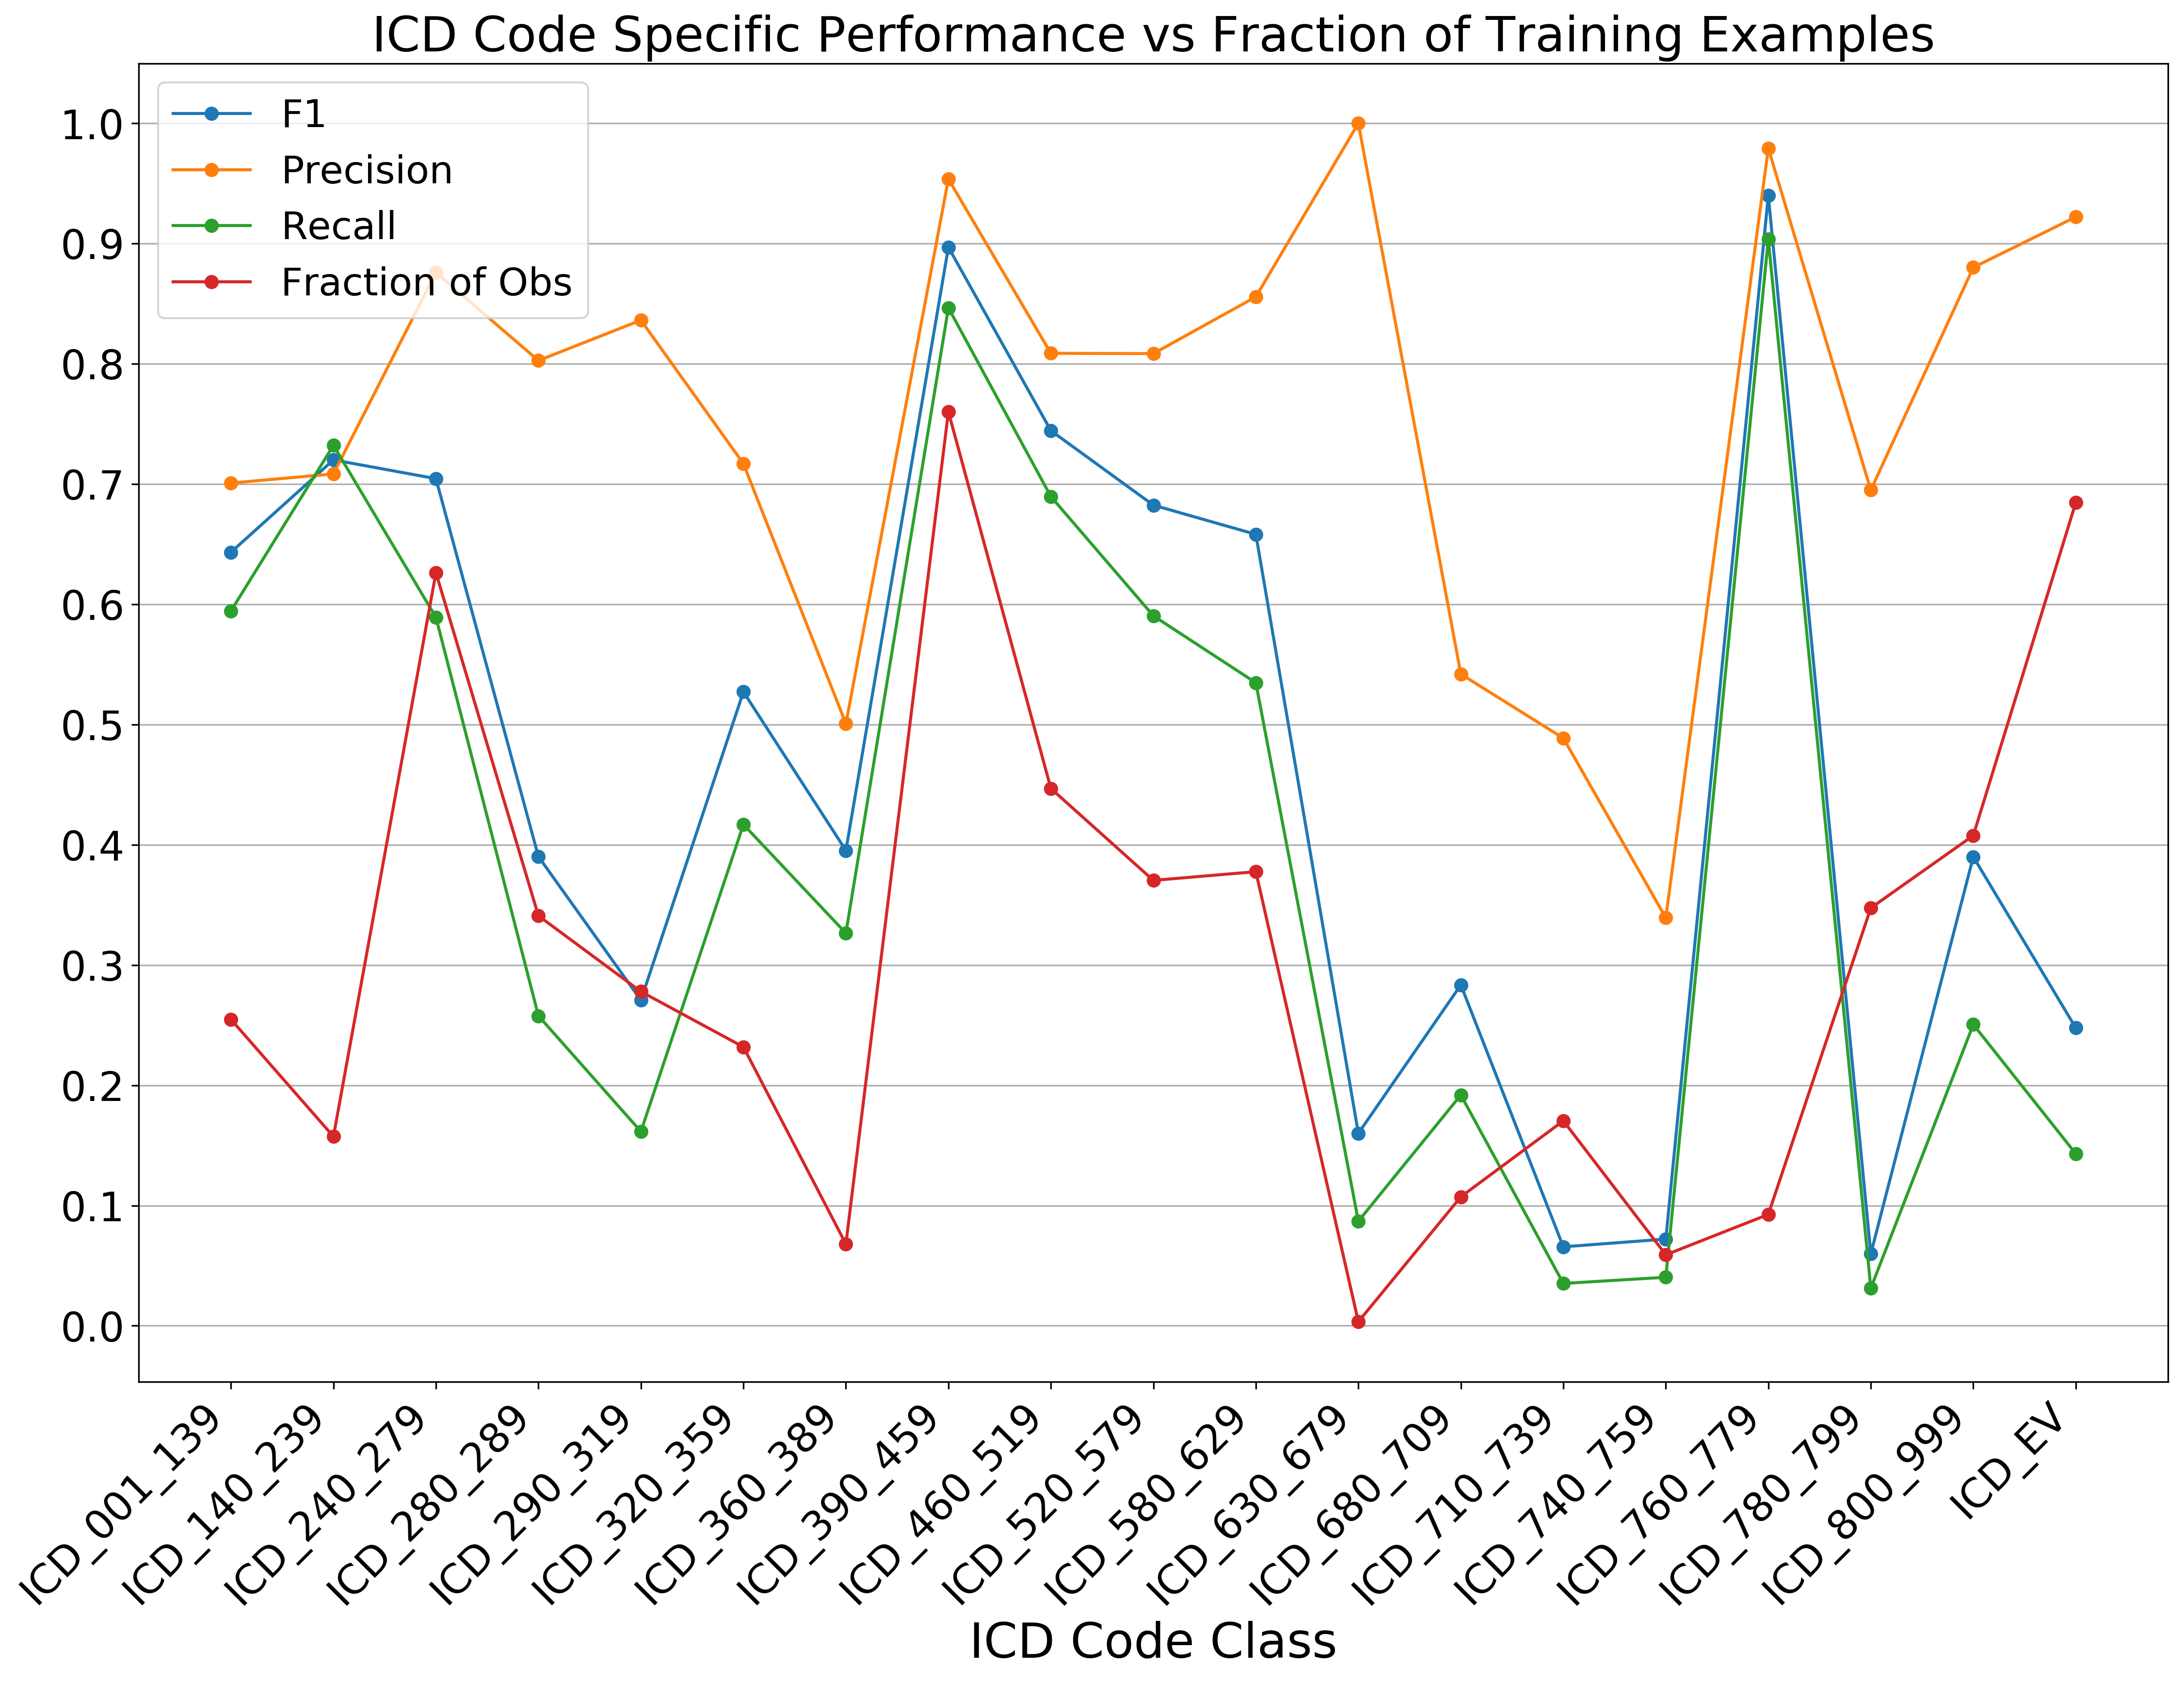

In [11]:
import matplotlib.pyplot as plt
from __future__ import division

nClasses = yTrain.shape[1]
width = 18
height = 12
fig = plt.figure(dpi = 300, figsize=(width, height))
x = range(1, nClasses + 1)
diseaseSpecificScores_F1 = [diseaseSpecificScores_F1[sortedIdx] for sortedIdx in sortedAxisLabels]
diseaseSpecificScores_Prec = [diseaseSpecificScores_Prec[sortedIdx] for sortedIdx in sortedAxisLabels]
diseaseSpecificScores_Rec = [diseaseSpecificScores_Rec[sortedIdx] for sortedIdx in sortedAxisLabels]
plt.plot(x, diseaseSpecificScores_F1, linestyle='-', marker='o', label = 'F1')
plt.plot(x, diseaseSpecificScores_Prec, linestyle='-', marker='o', label = 'Precision')
plt.plot(x, diseaseSpecificScores_Rec, linestyle='-', marker='o', label = 'Recall')
factionOfObsPerDisease = classTrainingExamples/yTrain.shape[0]
factionOfObsPerDisease = [factionOfObsPerDisease[sortedIdx] for sortedIdx in sortedAxisLabels]
my_xticks = xAxisLabels
my_xticks = [my_xticks[sortedIdx] for sortedIdx in sortedAxisLabels]
plt.plot(x, factionOfObsPerDisease, linestyle='-', marker='o', label ='Fraction of Obs')
plt.xticks(np.arange(1, nClasses + 1, 1.0), my_xticks, rotation=45, ha = 'right')
plt.yticks(np.arange(0, 1.1, 0.1))

plt.legend(loc='upper left', fontsize = 19)

plt.title('ICD Code Specific Performance vs Fraction of Training Examples', fontsize = 24)
plt.xlabel('ICD Code Class', fontsize = 24)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.gca().yaxis.grid(True)

plt.show()
fig.savefig(os.path.join(resultPath, 'diseaseSpecific.png'))

In [12]:
diseaseSpecificScores_F1

[0.64330543933054396,
 0.72010018785222296,
 0.70446672743846861,
 0.39019043704617073,
 0.27076705549664193,
 0.5272154745838955,
 0.39525222551928785,
 0.89692416060108004,
 0.74441493516638024,
 0.68245403677058347,
 0.65816376204848603,
 0.16,
 0.28345765686704694,
 0.065653495440729487,
 0.072106261859582535,
 0.94000000000000006,
 0.059820538384845467,
 0.39002574874644264,
 0.24766311892642295]